# We See
___
### *A Word Search Puzzle Solver*
This is a word search puzzle solver that uses computer vision and machine learning to extract the puzzle from an image and then find the requested word.
Currently, the puzzle is trained to only recognise printed text from (near-perfect) digitally created images and not from photographs - because the machine learning model is trained using a training set which contains just a single image of each character in the font used in the puzzle. This can later be improved by expanding the training set and correcting for rotations etc.

## Imports and Constants

Change the word to search for and the image to look in here.\
Make sure that the training image uses the same font as the puzzle image, and that the image sizes are not very different from the sample ones.\
The borders in the images must be in the same format as the sample ones:
- A single outer border in the puzzle image
- No border in the training image

This is to ensure that the contours are classified correctly.

In [26]:
%matplotlib inline
# IPython magic to show matplotlib plots inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from pandas import DataFrame

TRAINING_IMG = 'training.png'
TEST_IMG = 'test.png'
SEARCH_WORD = 'R'.lower()


## Utility Functions

Just pieces of code that were required at several places.

In [2]:
def img_show_out(title, img):
    '''
        Press any key to exit the window. Do not click on the cross icon.
    '''
    cv2.imshow(title, img)
    k = cv2.waitKey(0)
    cv2.destroyAllWindows()
    return k
    
def img_show_in(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # as opencv loads in BGR format by default, we want to show it in RGB.
    plt.show()

## Model Training
In this section, we train the letter recognition model using a single training image. This is enough because the font is the same and we are only targeting digitised puzzled, not pictures of a printed one.

### Preprocessing

#### Load the image

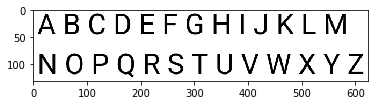

In [3]:
img = cv2.imread(TRAINING_IMG)
if img is None:
    print('Fatal error: Unable to load training image')
    raise SystemExit
img_copy = img.copy()
img_show_in(img)

#### Convert to greyscale

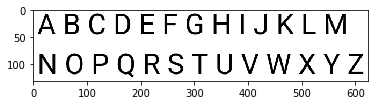

In [4]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_show_in(img)

#### Blur

This helps reduce noise in the image.

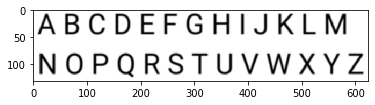

In [5]:
img = cv2.GaussianBlur(img, (5, 5), 0)
img_show_in(img)

#### Binarise

Convert the image to a binary color scheme (black/white) by thresholding on the intensity of each pixel. We use an adaptive threshold, i.e., the threshold is determined separately for every pixel using the pixels around it. This helps compensate for illumination differences across the image.

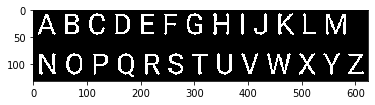

In [6]:
img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
# 11 is size of grid, 2 is the value to subtract from Gaussian weighted mean while calculating threshold for each cell
img_show_in(img)

#### Extract Contours

Contours are boundaries marking regions of pixels with similar intensities.\
We extract only the outermost counters in this step (`cv2.RETR_EXTERNAL`) because they correspond to the outer boundaries of the alphabets. A couple of points to note:
- Because the outermost counters are treated as the letters, it is necessary that the training image not have a border around it. This requirement can be relaxed by counting the number of outermost contours and if it's only 1, detecting it as a border and ignoring it
- If the letters used are lowercase, then disconnected components (like the dot on `i` or `j`) are treated as separate counters and are ignored at a later step (because of their size/area being too small). This may cause the model to confuse between letters that look similar without those components, such as `i` and `l`

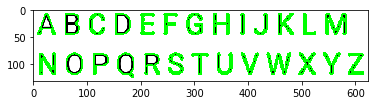

In [7]:
contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
temp = img_copy.copy()
cv2.drawContours(temp, contours, -1, (0, 255, 0), 2)
img_show_in(temp)
# Retrieving only the external (outermost) contours creates one contour per alphabet, ignoring internal contours within the alphabets, such as the hole in A or B

### Collect Responses

In [8]:
samples = np.empty((0, 100))
responses = []

keys = [i for i in range(97, 123)]
# letters a (97) to z (122)

At this step, we loop through all the contours, and if they are big enough, we ask the user to tell us what letter that contour represents. This builds the training set for our machine learning model.

In [9]:
temp = img_copy.copy()

for cnt in contours:
    
    if cv2.contourArea(cnt) < 50:
            continue

    x, y, w, h = cv2.boundingRect(cnt)

    if h < 18:
        continue
    
    interest_region = img[y: y+h, x: x+w] # get the region of interest from the img
    interest_region = cv2.resize(interest_region, (10, 10)) # resize to 10 rows and cols
    
    cv2.rectangle(temp, (x, y), (x+w, y+h), (0, 0, 255), 2) # surround current contour with red box
    
    success = False
    while not success:        
        key = img_show_out("Green: Already trained | Red: Currently training", temp)

        if key == 27: # ESC
            raise SystemExit
        elif key in keys:
            success = True
            responses.append(key)
            sample = interest_region.reshape((1, 100)) # flatten it to [[1, 0, 0, v, a, l, u, e, s, ],]
            samples = np.append(samples, sample, 0) # append sample to samples along the vertical axis

    cv2.rectangle(temp, (x, y), (x+w, y+h), (0, 255, 0), 2) # surround done contour with green box

In [10]:
samples = np.float32(samples)
samples

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ...,   0.,   0.,   0.],
       [243., 255., 255., ...,   0., 255., 255.],
       ...,
       [255., 255.,   0., ...,   0., 255., 255.],
       [  0.,   0., 128., ..., 255.,   0.,   0.],
       [  0.,   0.,  96., ..., 128.,   0.,   0.]], dtype=float32)

In [11]:
responses = np.array(responses, np.float32)
responses = responses.reshape((responses.size, 1))
responses

array([[122.],
       [116.],
       [114.],
       [112.],
       [121.],
       [120.],
       [119.],
       [118.],
       [117.],
       [115.],
       [113.],
       [111.],
       [110.],
       [109.],
       [102.],
       [101.],
       [100.],
       [ 98.],
       [ 97.],
       [108.],
       [107.],
       [106.],
       [105.],
       [104.],
       [103.],
       [ 99.]], dtype=float32)

In [12]:
np.savetxt('data/train-samples.txt', samples)
np.savetxt('data/train-responses.txt', responses)

In [13]:
# Uncomment this cell and run from here if you want to use saved training data
# samples = np.loadtxt('data/train-samples.txt', np.float32)
# responses = np.loadtxt('data/train-responses.txt', np.float32)
responses = responses.reshape((responses.size, 1))

We use the nearest neighbour model to recognise characters. This classification model classifies a data point on the feature space in the same category as its nearest neighbour.

In [14]:
model = cv2.ml.KNearest_create()
model.train(samples, cv2.ml.ROW_SAMPLE, responses)

True

## Application on Test Data

Now that we have a trained model, we can use it to extract letters out of the puzzle and create a digitised version, which can then be searched for the requested word.

### Preprocessing

#### Load the image

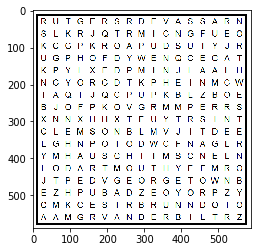

In [27]:
img = cv2.imread(TEST_IMG)
if img is None:
    print('Fatal error: Unable to load training image')
    raise SystemExit
img_copy = img.copy()
img_show_in(img)

#### Convert to grey

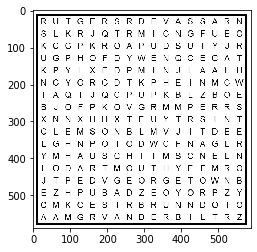

In [28]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_show_in(img)

#### Blur

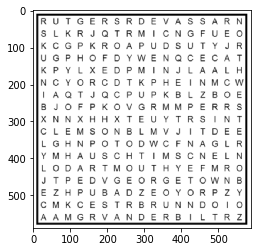

In [29]:
img = cv2.GaussianBlur(img, (5, 5), 0)
img_show_in(img)

#### Binarise

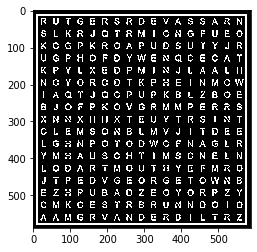

In [30]:
img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
# 11 is size of grid, 2 is the value to subtract from Gaussian weighted mean while calculating threshold for each cell
img_show_in(img)

#### Extract Contours
Here, we extract contours using a 2-level hierarchy. Thus, all odd-level contours are classified as level 1, while even-level ones are classified as level 2. Thus the border's outer boundary is level 1, inner boundary is level 2, and the outer boundaries of all letters are level 1, while inner boundaries of letters like `O`, `P`, `B`, `R`, `D` etc. are classified as level 2. Thus, selecting all level 1 contours within a reasonable size range (not as big as the entire board's border, not as small as the dot on a lowercase `i`) gives us all the letters in the board.

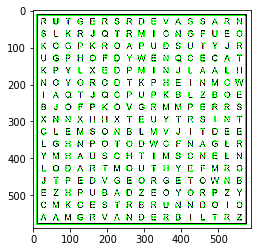

In [31]:
contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
# RETR_CCOMP arranges all contours in a 2-level hierarchy. A contour, it's child. Anything inside will again start from hierarchy level 1. So the outer boundary of the board in hierarchy 1, the inner boundary is 2. All letters have their outer boundaries as 1 and inner holes as 2.
hierarchy = hierarchy[0] # it has more dimensions than reqd
temp = img_copy.copy()
cv2.drawContours(temp, contours, -1, (0, 255, 0), 1)
img_show_in(temp)

### Read the Board
The contours that are the right size for a letter are fed into the trained model to find the correponsing letter, which is stored in a 2 dimensional array, along with coordinate information that helps us highlight the found word later.

In [32]:
board = []
board_detail = []

for i in range(len(contours)):
    cnt = contours[i]
    if cv2.contourArea(cnt) < 50 or cv2.contourArea(cnt) > 250:
#       Only allow contours the size of a letter. Gets rid of the entire board
        continue
    if hierarchy[i][3] != -1:
#       Gets rid of level-2 contours
        continue
    
    x, y, w, h = cv2.boundingRect(cnt)
    interest_region = img[y: y+h, x: x+w]
    interest_region = cv2.resize(interest_region, (10, 10))
    interest_region = interest_region.reshape((1, 100))
    interest_region = np.float32(interest_region)
    ret, results, neigh_disp, dists = model.findNearest(interest_region, k=1)
    
    board.append(chr(results[0][0])) # results has more dimensions than reqd. Only contains a single value
    board_detail.append((x, y, w, h))

In [33]:
board = list(reversed(board))
board = np.array(board)
l = int(math.sqrt(len(board)))
board = np.reshape(board, (l, -1))
print(DataFrame(board))

    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16
0   r  u  t  g  e  r  s  r  d  e  v  a  s  s  a  r  n
1   s  l  k  r  j  q  t  r  m  i  c  n  g  f  u  e  o
2   k  c  g  p  k  r  o  a  p  u  d  s  u  t  y  j  r
3   u  g  p  h  o  f  d  y  w  e  n  q  c  e  c  a  t
4   k  p  y  l  x  e  d  p  m  i  n  j  l  a  a  l  h
5   n  c  y  o  r  c  d  t  k  p  h  e  i  n  m  c  w
6   i  a  q  t  j  q  c  p  u  p  k  b  l  z  b  o  e
7   b  j  o  f  p  k  o  v  g  r  m  m  p  e  r  r  s
8   x  n  n  x  h  h  x  t  e  u  y  t  r  s  i  n  t
9   c  l  e  m  s  o  n  b  l  m  v  j  i  t  d  e  e
10  l  g  h  n  p  o  t  o  d  w  c  f  n  a  g  l  r
11  y  m  h  a  u  s  c  h  t  i  m  s  c  n  e  l  n
12  l  o  d  a  r  t  m  o  u  t  h  y  e  f  m  r  o
13  j  t  p  e  d  v  g  e  o  r  g  e  t  o  w  n  b
14  e  z  h  p  u  b  a  d  z  e  o  y  o  r  p  z  y
15  c  m  k  c  e  s  t  r  b  r  u  n  n  d  o  i  o
16  a  a  m  g  r  v  a  n  d  e  r  b  i  l  t  r  z


In [34]:
board_detail = list(reversed(board_detail))
board_detail

[(21, 21, 16, 19),
 (54, 21, 15, 19),
 (88, 21, 14, 19),
 (119, 21, 17, 19),
 (154, 21, 14, 19),
 (186, 21, 16, 19),
 (219, 21, 15, 19),
 (252, 21, 16, 19),
 (285, 21, 16, 19),
 (319, 21, 14, 19),
 (351, 21, 15, 19),
 (383, 21, 17, 19),
 (417, 21, 15, 19),
 (450, 21, 15, 19),
 (482, 21, 17, 19),
 (516, 21, 16, 19),
 (549, 21, 15, 19),
 (21, 54, 15, 19),
 (56, 54, 12, 19),
 (88, 54, 14, 19),
 (120, 54, 16, 19),
 (155, 54, 11, 19),
 (185, 54, 18, 20),
 (220, 54, 14, 19),
 (252, 54, 16, 19),
 (284, 54, 17, 19),
 (324, 54, 4, 19),
 (351, 54, 16, 19),
 (384, 54, 15, 19),
 (416, 54, 17, 19),
 (452, 54, 13, 19),
 (483, 54, 15, 19),
 (517, 54, 14, 19),
 (548, 54, 18, 19),
 (22, 87, 14, 19),
 (54, 87, 16, 19),
 (86, 87, 17, 19),
 (121, 87, 14, 19),
 (154, 87, 14, 19),
 (186, 87, 16, 19),
 (218, 87, 18, 19),
 (251, 87, 17, 19),
 (286, 87, 14, 19),
 (318, 87, 15, 19),
 (351, 87, 16, 19),
 (384, 87, 15, 19),
 (417, 87, 15, 19),
 (451, 87, 14, 19),
 (484, 87, 14, 19),
 (518, 87, 11, 19),
 (549, 87,

## Solve the Puzzle
The puzzle solving algorithm is brute-force, searching for the word in every direction from every occurence of the starting letter

In [35]:
ORIENT_NN = 0
ORIENT_NE = 1
ORIENT_EE = 2
ORIENT_SE = 3
ORIENT_SS = 4
ORIENT_SW = 5
ORIENT_WW = 6
ORIENT_NW = 7

def search(word, board, i, j):
    if len(word) == 0 or len(board) == 0 or len(board[0]) == 0:
        return False, [], -1
    
    if i < 0 or i >= len(board) or j < 0 or j >= len(board[0]):
        return False, [], -1
    
    h = len(board)
    w = len(board[0])
    
    if board[i][j] != word[0]:
        return False, [], -1
    
#       N
#     W + E
#       S
    
    answer = []
#     NORTH
    if i + 1 >= len(word):
        for g in range(len(word)):
            if word[g] != board[i - g][j]:
                answer.clear()
                break                
            answer.append((i-g, j))
        
        else: # did not break
            return True, answer, ORIENT_NN
        
#     NORTHEAST
    if i + 1 >= len(word) and w - j >= len(word):
        for g in range(len(word)):
            if word[g] != board[i - g][j + g]:
                answer.clear()
                break                
            answer.append((i - g, j + g))
        
        else: # did not break
            return True, answer, ORIENT_NE
        
#     EAST
    if w - j >= len(word):
        for g in range(len(word)):
            if word[g] != board[i][j + g]:
                answer.clear()
                break                
            answer.append((i, j + g))
        
        else: # did not break
            return True, answer, ORIENT_EE
        
#     SOUTHEAST
    if h - i >= len(word) and w - j >= len(word):
        for g in range(len(word)):
            if word[g] != board[i + g][j + g]:
                answer.clear()
                break                
            answer.append((i + g, j + g))
        
        else: # did not break
            return True, answer, ORIENT_SE
        
#     SOUTH
    if h - i >= len(word):
        for g in range(len(word)):
            if word[g] != board[i + g][j]:
                answer.clear()
                break                
            answer.append((i + g, j))
        
        else: # did not break
            return True, answer, ORIENT_SS
        
#     SOUTHWEST
    if h - i >= len(word) and j + 1 >= len(word):
        for g in range(len(word)):
            if word[g] != board[i + g][j - g]:
                answer.clear()
                break                
            answer.append((i + g, j - g))
        
        else: # did not break
            return True, answer, ORIENT_SW
        
#     WEST
    if j + 1 >= len(word):
        for g in range(len(word)):
            if word[g] != board[i][j - g]:
                answer.clear()
                break                
            answer.append((i, j - g))
        
        else: # did not break
            return True, answer, ORIENT_WW
        
#     NORTHWEST
    if i + 1 >= len(word) and j + 1 >= len(word):
        for g in range(len(word)):
            if word[g] != board[i - g][j - g]:
                answer.clear()
                break                
            answer.append((i - g, j - g))
        
        else: # did not break
            return True, answer, ORIENT_NW
        
    return False, [], -1

In [36]:
if len(board) == 0 or len(board[0]) == 0:
    print('Board is empty')
    raise SystemExit

flag = False
for i in range(len(board)):
    for j in range(len(board[0])):
        
        ret, answer, orient = search(SEARCH_WORD, board, i, j)
        if ret == True:
            flag = True
            break
    
    if flag == True:
        break 

answer

[(0, 0)]

In [ ]:
if flag == False:
    print('Word not found :(')
else:
    start = board_detail[answer[0][0] * len(board[0]) + answer[0][1]]
    end = board_detail[answer[-1][0] * len(board[0]) + answer[-1][1]]
    
#       N
#     W + E
#       S
    
    if orient == ORIENT_SS:
        start, end = end, start
    
    if orient == ORIENT_SS or orient == ORIENT_NN:
        points = np.array([
            [end[0] - 5, end[1] - 5],
            [end[0] + end[2] + 5, end[1] - 5],
            [start[0] + start[2] + 5, start[1] + start[3] + 5],
            [start[0] - 5, start[1] + start[3] + 5]
        ], np.int32)
        
    if orient == ORIENT_SW:
        start, end = end, start
        
    if orient == ORIENT_SW or orient == ORIENT_NE:
        points = np.array([
            [start[0] - 5, start[1] - 5],
            [start[0] - 5, start[1] + start[3] + 5],
            [start[0] + start[2] + 5, start[1] + start[3] + 5],
            [end[0] + end[2] + 5, end[1] + end[3] + 5],
            [end[0] + end[2] + 5, end[1] - 5],
            [end[0] - 5, end[1] - 5]
        ], np.int32)
        
    if orient == ORIENT_WW:
        start, end = end, start
        
    if orient == ORIENT_WW or orient == ORIENT_EE:
        points = np.array([
            [start[0] - 5, start[1] - 5],
            [start[0] - 5, start[1] + start[3] + 5],
            [end[0] + end[2] + 5, end[1] + end[3] + 5],
            [end[0] + end[2] + 5, end[1] - 5]
        ], np.int32)
        
    if orient == ORIENT_NW:
        start, end = end, start
        
    if orient == ORIENT_NW or orient == ORIENT_SE:
        points = np.array([
            [start[0] + start[2] + 5, start[1] - 5],
            [start[0] - 5, start[1] - 5],
            [start[0] - 5, start[1] + start[3] + 5],
            [end[0] - 5, end[1] + end[3] + 5],
            [end[0] + end[2] + 5, end[1] + end[3] + 5],
            [end[0] + end[2] + 5, end[1] - 5]
        ], np.int32)

    
    points.reshape((-1, 1, 2)) # each point in its own dimension
    final = img_copy.copy()
    
    cv2.polylines(final, [points], True, (0, 0, 255), 2)
    
    img_show_out('Answer', final)